# Image edge detection module

## High level overview:

1.  Define a `tf.Module` containing a `@tf.function` that performs edge detection
2.  Save the `tf.Module` as a `SavedModel`
3.  Use IREE's python bindings to load the `SavedModel` into MLIR in the `mhlo` dialect
4.  Save the MLIR to a file (can stop here to use it from another application)
5.  Compile the `mhlo` MLIR into a VM module for IREE to execute
6.  Run the VM module through IREE's runtime to test the edge detection function

In [0]:
#@title Imports and common setup

import os
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from pyiree.tf import compiler as ireec
from pyiree import rt as ireert

SAVE_PATH = os.path.join(os.environ["HOME"], "saved_models")
os.makedirs(SAVE_PATH, exist_ok=True)

In [2]:
#@title Construct a module containing the edge detection function

class EdgeDetectionModule(tf.Module):
  @tf.function(input_signature=[tf.TensorSpec([1, 128, 128, 1], tf.float32)])
  def edge_detect_sobel_operator(self, image):
    # https://en.wikipedia.org/wiki/Sobel_operator
    sobel_x = tf.constant([[-1.0, 0.0, 1.0],
                           [-2.0, 0.0, 2.0],
                           [-1.0, 0.0, 1.0]],
                          dtype=tf.float32, shape=[3, 3, 1, 1])    
    sobel_y = tf.constant([[ 1.0,  2.0,  1.0],
                           [ 0.0,  0.0,  0.0],
                           [-1.0, -2.0, -1.0]],
                          dtype=tf.float32, shape=[3, 3, 1, 1])
    gx = tf.nn.conv2d(image, sobel_x, 1, "SAME")
    gy = tf.nn.conv2d(image, sobel_y, 1, "SAME")
    return tf.math.sqrt(gx * gx + gy * gy)

tf_module = EdgeDetectionModule()
saved_model_path = os.path.join(SAVE_PATH, "edge_detection.sm")
save_options = tf.saved_model.SaveOptions(save_debug_info=True)
tf.saved_model.save(tf_module, saved_model_path, options=save_options)

# Compile from SavedModel to MLIR mhlo, then save to a file.
# 
# Do *not* further compile to a bytecode module for a particular backend.
# 
# By stopping at mhlo in text format, we can more easily take advantage of
# future compiler improvements within IREE and can use iree_bytecode_module to
# compile and bundle the module into a sample application. For a production
# application, we would probably want to freeze the version of IREE used and
# compile as completely as possible ahead of time, then use some other scheme
# to load the module into the application at runtime.
compiler_module = ireec.tf_load_saved_model(saved_model_path)
print("Edge Detection MLIR:", compiler_module.to_asm())

edge_detection_mlir_path = os.path.join(SAVE_PATH, "edge_detection.mlir")
with open(edge_detection_mlir_path, "wt") as output_file:
  output_file.write(compiler_module.to_asm())
print("Wrote MLIR to path '%s'" % edge_detection_mlir_path)

INFO:tensorflow:Assets written to: /usr/local/google/home/scotttodd/saved_models/edge_detection.sm/assets
Edge Detection MLIR: 

module attributes {tf.versions = {bad_consumers = [], min_consumer = 12 : i32, producer = 175 : i32}} {
  func @edge_detect_sobel_operator(%arg0: tensor<1x128x128x1xf32>) -> tensor<1x128x128x1xf32> attributes {iree.module.export, iree.reflection = {abi = "sip", abiv = 1 : i32, sip = "I8!S5!k0_0R3!_0"}, tf._input_shapes = ["tfshape$dim { size: 1 } dim { size: 128 } dim { size: 128 } dim { size: 1 }"]} {
    %0 = mhlo.constant dense<[[[[-1.000000e+00]], [[0.000000e+00]], [[1.000000e+00]]], [[[-2.000000e+00]], [[0.000000e+00]], [[2.000000e+00]]], [[[-1.000000e+00]], [[0.000000e+00]], [[1.000000e+00]]]]> : tensor<3x3x1x1xf32>
    %1 = mhlo.constant dense<[[[[1.000000e+00]], [[2.000000e+00]], [[1.000000e+00]]], [[[0.000000e+00]], [[0.000000e+00]], [[0.000000e+00]]], [[[-1.000000e+00]], [[-2.000000e+00]], [[-1.000000e+00]]]]> : tensor<3x3x1x1xf32>
    %2 = "mhlo.co

In [3]:
#@title Prepare to test the edge detection module

TARGET_BACKENDS = ("vulkan-spirv",)
DRIVER_NAME = "vulkan"

flatbuffer_blob = compiler_module.compile(target_backends=TARGET_BACKENDS)
vm_module = ireert.VmModule.from_flatbuffer(flatbuffer_blob)

# Register the module with a runtime context.
config = ireert.Config(DRIVER_NAME)
ctx = ireert.SystemContext(config=config)
ctx.add_module(vm_module)

Created IREE driver vulkan: <pyiree.rt.binding.HalDriver object at 0x7ff712a0f0b0>
SystemContext driver=<pyiree.rt.binding.HalDriver object at 0x7ff712a0f0b0>


In [0]:
#@title Load a test image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)

def load_image(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (128, 128))
  image = image[tf.newaxis, :]
  return image

content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_image(content_path)

Invoke edge_detect_sobel_operator
Input:


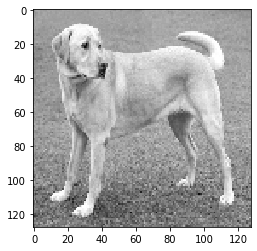

Output:


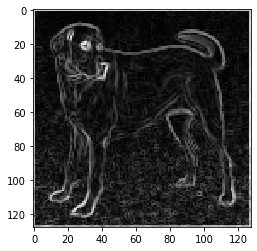

In [5]:
#@title Test the "edge_detect_sobel_operator" function

edge_detect_sobel_operator_f = ctx.modules.module["edge_detect_sobel_operator"]

# Invoke the function with the image as an argument
print("Invoke edge_detect_sobel_operator")
result = edge_detect_sobel_operator_f(content_image.numpy())

# Plot the input and output images
print("Input:")
plt.imshow(content_image.numpy().reshape(128, 128), cmap="gray")
plt.show()
print("Output:")
plt.imshow(result.reshape(128, 128), cmap="gray")
plt.show()